#  Convolutional neural network
# Reconnaissance Optique de Caractères avec TensorFlow

## Objectif :
Nous allons voir comment apprendre à reconnaître des caractères optiques avec TensorFlow.

(OCR : Optical Caracter Recognition)

Il s'agit de concevoir un modèle de Deep Learning afin de reconnaître des chiffres traçés à la main.

Ce type d'application est déployé pour la lecture optique des chèques bancaires par exemple.

Nous allons écrire un Réseau de neurones à Convolution afin de reconnaître les caractères manuscrits.

C'est un problème de classification multiple (10 chiffres possible => 10 classes)

In [2]:
# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (chiffres manuscrits de 0-9)
dropout = 0.25 # Dropout, probabilité de drop un neurone du réseau

## Importation des librairies 
On importe les données nécessaires depuis TensorFlow. TensorFlow embarque un ensemble de data-sets.

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# fix verbosity
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
non-resource variables are not supported in the long term


ModuleNotFoundError: No module named 'tensorflow.examples.tutorials'

## Visualiser le data-set

In [3]:
import matplotlib.pyplot as pl

print mnist.train.images.shape

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(mnist.train.images.shape)? (<ipython-input-3-c6201bad31eb>, line 3)

### Redimension :
On choisit une image du datat-set.

On passe d'une dimension *784* à *28 x 28* pour pouvoir afficher l'image choisit

In [19]:
img_nb = 14
img  = mnist.train.images[img_nb]

# avant re dimension
print(img.shape)

# 784 -> 28 x 28
img = mnist.train.images[img_nb].reshape(28,28)

# après re dimension
print(img.shape)

(784,)
(28, 28)


### Plot

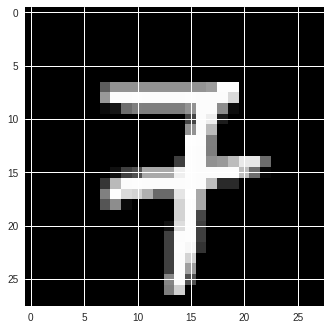

In [20]:
pl.imshow(img ,cmap = pl.get_cmap('gray'))

## Input layer : les placeHolders
Les  noeud nommés **placeholder** ne réalisent **aucun** calcul. Ils sont chargé d'alimenter, d'emettre des données à l'exécution (*run time*).

Dimension du placeholder attendu par TF  :
```
 [batch_size, image_height, image_width, channels]
```

 -1 pour  batch size : cette dimension est calculee à la volee (*runtime*).
 
Ceci permet d'effectuer des *batch* dont la dimension sera basée sur le nombre de valeur d entrée *(features["x"])*


In [0]:
x = tf.placeholder("float", shape=[None, num_input])
y_ = tf.placeholder("float", shape=[None, num_classes])
# image 28 x 28 ; N&B <=> channel = 1

x_image = tf.reshape(x, [-1,28,28,1])

## Fonctions de construction 
Nous déportons dans des fonctions les opérations 
* initialisation des variables et des constantes
* construction des couches de convolution
* construction des couches de Pooling

In [0]:
# poids et constantes dans des fonctions (+lisible) 
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

## Architecture du CNN 

Le réseau que l'on va construire ensemble :
```
input :
image : 784 pixels (28 x 28) 
Réseau : 
couche_conv#1
 [CONV - ReLu - Pool] 
couche_conv#2
 [CONV - ReLu - Pool] 
 couche_dense#1
 [DENSE - Drop-out] 
 couche_decision
 [DENSE - softmax] 

output :
probabilité appartenance à une classe {0,1,2,...,9}
```



L'architecture du réseau, les différentes couches sont les suivantes :
* couche convolution  #1:

applique 32 filtres 5x5  , activation ReLu
* couche Pooling  #1: 

applique *max pooling* filtre 2x2  stride = 2 (*no overlap*)
* couche convolution #2: 

applique 64 filtres 5x5, ReLU 
* couche Pooling  #2: 

idem pooling#1
* couche dense  #1: 

1,024 neurones, régularisation *dropout*, (probabilité élagage durant apprentissage)
* couche dense #2 (couche Logits): 10 neurones, un pour chaque classe de chiffres manuscrits (nombre entre 0 et9).





## Détails de construction des couches de Pooling, convolution et dense
Cette partie technique est à passer en 1ère lecture
### Convolution
* stride de 1 dans chaque dimension ```
strides = [1, 1, 1, 1] ```


* zero padding : "SAME"

Ce type de *padding* préserve la dimension de l'image retournée

``` 
  tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
```

Souvent, on ne souhaite pas effectuer un *downsampling* trop prématuré. Dans ce cas, on choisit de préserver à l'aide d'un *padding* approprié.

### Pooling
L'opération de *pooling* qui est implémenté est une opération "max". 
C'est donc une couche *max_pool*

fenêtre 2 x 2, *stride* de 2 
(pas de chevauchement : *over-lapp*) puis calcul du maximum au sein de chaque fenetre
```
tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')
```
### Couche dense 
La couche dense est souvent nommé : * fully connected layer*

C'est la couche chargée d'effectuer la classification des caractéristiques (*features*) 
* extraits par les couches de convolution 
* réduits par les couches de *pooling*

La couche finale *W_fc2* contient une cellule (*node*) pour chaque classe à prédire (10 classes)




## Fonctions de construction des couches
* input : tenseur (*tensor*)
* output : tenseur

### Chaînage des couches
Les couches sont liées entre elles de la façon suivante: 

L'output de la couche précédente servira d'*input* à la couche suivante

In [0]:
# les operations au sein du reseau CNN (convolution et max pool)
def conv2d(x, W):
  #stride de 1 dans chaque dimension (zero padding : "SAME") 
 return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  
  # zero padding model : preserve la dimension  (SAME)
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                      strides=[1, 2, 2, 1], padding='SAME')

## Couche convolution #1
* **inputs** : images 28 x 28
* Transformation : convolution 5 x 5 
* **output** : 32 *feature maps*
* activation *reLu*
* max-pool 2 x 2

Lien de connection : *h_pool1*


Important pour comprendre le détail des mécanismes de la convolution mais **à passer en 1ère lecture** :

Dimension *h_pool1*  (tenseur)
```
 [batch_size,height,width,channels] = [-1, 14, 14, 32]

```
L'opération de **Pooling**, *max_pool_2x2*, reduit la dimension (*down-sampling*) de 50% des images d'origine.
En conséquence, 

taille 28 x 28 -> max Pool -> taille 14 x 14

In [0]:
# dimension du tensor : [filter_size , filter_size , channel , #features #filtres (output dim)]
# filter_size : 5 x 5
filter_size = 5
# sur le couche de convolution#1, channel = 1 (image N&B) 
channel = 1
nb_features = 32
W_conv1 = weight_variable([filter_size, filter_size, channel, nb_features])
# 1 biais pour chaque matrice de poids (nb_features)
b_conv1 = bias_variable([nb_features])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
# max-pooling (conservation du maximum calculé sur des fenêtres 2x2) 
h_pool1 = max_pool_2x2(h_conv1)

## Couche convolution #2
* **inputs** : 32 *feature maps* (= *input* de la couche précédente, *pooling*)
* Transformation : convolution 5 x 5 
* **output** : 64 *feature maps*
* activation *reLu*
* max-pool 2 x 2

Lien de connection : *h_pool2*

Important pour comprendre le détail des mécanismes de la convolution mais **à passer en 1ère lecture** :

Dimension *h_pool2*  (tenseur)
```
 [batch_size, image_height, image_width, channels] =
 
 [-1, 7, 7, 32]

```
car *max_pool_2x2* reduit la dimension (*down-sampling*) de 50% des images précédentes (taille 14 x 14)

taille 14 x 14 -> max Pool -> taille 7 x 7

In [0]:
# input : output de la 1ère couche de convolution
channel = nb_features
# output de la 2ème couche de convolution:
nb_features = 64
W_conv2 = weight_variable([filter_size, filter_size, channel ,nb_features])
b_conv2 = bias_variable([nb_features])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)


## Couche dense
Cette couche va se charger de l'analyse des "structures" (*feature maps*) émises par la dernière couche de convolution.

C'est une couche dense (*fully connected*)

In [0]:
# dim_out : 64 filtres taille 7 x 7 (2e couche de convolution)
dim_out = 7 * 7 * 64 
# nb neurones de la couche
nb_neurons = 1024
#dim_2 = nb_neurons
W_fc1 = weight_variable([dim_out, nb_neurons])
b_fc1 = bias_variable([nb_neurons])

# flatten : tensor -> vector:
# mult matrice de poids W_fc1 x flatten vect (h_pool2_flat)
# puis addition biais (b_fc1) et application fonction activation ReLU 
h_pool2_flat = tf.reshape(h_pool2, [-1, dim_out])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Couche finale
C'est la couche de décision. Celle qui effectue la classification
### Drop-out
La couche finale est **régularisée** afin d'augmenter la performance du modèle.
L'opération de **Drop-out** évite aux neurones de se sur-spécialiser.


Point technique important (passer en 1ère lecture):
Le *drop-out* ne concerne **que** la phase d'apprentissage.
Durant la phase de test, les neurones ne sont pas élagués. C'est pourquoi, durant cette phase, on indique :

```keep_prob: 1.0
```

Idem, durant les phases de reporting : pas de *droup-out*

### softmax
Cette fonction émet une probabilité d'appartenance à chaque classe pour chaque image analysée.

In [0]:
keep_prob = tf.placeholder("float")
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([nb_neurons, num_classes])
b_fc2 = bias_variable([num_classes])
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

## Apprentissage
Les paramètres de l'apprentissage sont les suivants
* taux d'apprentissage (*learning_rate*)
* nb d'itérations total (*epochs*)
* taille des batchs (*batch_size*)

In [0]:
learning_rate = 0.001
epochs = 2000 
batch_size = 128

In [0]:
# fonction de calcul de l'erreur
cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
# optimizer
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
# prédiction correcte ?
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
# métrique de performance
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

In [38]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(epochs):
     batch_xs, batch_ys = mnist.train.next_batch(batch_size)
     sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: dropout})
     if i % 100 == 0:
          train_accuracy = sess.run(accuracy, feed_dict={x: batch_xs, y_: batch_ys,
               keep_prob: 1.0})
          print("Step %d - Train accuracy %.3f" % (i, train_accuracy))
                    
          test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels,
                                  keep_prob: 1.0})
          print("Step %d - Test accuracy %.3f" % (i, test_accuracy))
          print("")
          
test_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels,
keep_prob: 1.0})
print("Test accuracy %.3f" % test_accuracy) 

tf.logging.set_verbosity(old_v)

Step 0 - Train accuracy 0.133
Step 0 - Test accuracy 0.117

Step 100 - Train accuracy 0.922
Step 100 - Test accuracy 0.955

Step 200 - Train accuracy 0.992
Step 200 - Test accuracy 0.970

Step 300 - Train accuracy 0.977
Step 300 - Test accuracy 0.978

Step 400 - Train accuracy 0.969
Step 400 - Test accuracy 0.979

Step 500 - Train accuracy 0.992
Step 500 - Test accuracy 0.983

Step 600 - Train accuracy 0.992
Step 600 - Test accuracy 0.984

Step 700 - Train accuracy 0.984
Step 700 - Test accuracy 0.984

Step 800 - Train accuracy 0.984
Step 800 - Test accuracy 0.987

Step 900 - Train accuracy 0.992
Step 900 - Test accuracy 0.988

Step 1000 - Train accuracy 0.984
Step 1000 - Test accuracy 0.988

Step 1100 - Train accuracy 0.992
Step 1100 - Test accuracy 0.989

Step 1200 - Train accuracy 1.000
Step 1200 - Test accuracy 0.991

Step 1300 - Train accuracy 0.992
Step 1300 - Test accuracy 0.990

Step 1400 - Train accuracy 1.000
Step 1400 - Test accuracy 0.989

Step 1500 - Train accuracy 1.000
S